<a href="https://colab.research.google.com/github/gianguyen7/Recommender-System-ALS/blob/main/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DS340W Final Code
###Gia Nguyen & Yoojin Lim

####**Notebook Agenda**
1. Dictionary
2. EDA
3. Data preprocessing

*Novelty Implementation*
5. Implement ALS to iterate over algorithms
6. Training & predicting over BaselineOnly algorithm
7. Inspect predictions in detail

##**Dictionary**

In [ ]:
'''
reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
asin - ID of the product, e.g. 0000013714
reviewerName - name of the reviewer
helpful - helpfulness rating of the review, e.g. 2/3
reviewText - text of the review
overall - rating of the product
summary - summary of the review
unixReviewTime - time of the review (unix time)
reviewTime - time of the review (raw)
'''

'\nreviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B\nasin - ID of the product, e.g. 0000013714\nreviewerName - name of the reviewer\nhelpful - helpfulness rating of the review, e.g. 2/3\nreviewText - text of the review\noverall - rating of the product\nsummary - summary of the review\nunixReviewTime - time of the review (unix time)\nreviewTime - time of the review (raw)\n'

##**EDA**

In [ ]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Read in the Data
data = pd.read_csv("/content/gdrive/My Drive/DS 340W/musical_instruments.csv")
data.head(5)

,reviewerID,asin,reviewerName,helpful/0,helpful/1,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...",0,0,"Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,13,14,The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",1,1,The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",0,0,Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,0,0,This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
#Observing rating counts distribution
ratingCount =  data.groupby(['overall'])
ratingCount = ratingCount['overall'].count()
ratingCount = ratingCount.nlargest(10, 'first')
ratingCount = px.bar(ratingCount, x = 'overall', title = 'Top Rating Counts', width = 800, height = 800)
ratingCount.update_layout(yaxis_title = "overall", xaxis_title = "count")
ratingCount.show()

##**Data Preprocessing**

In [ ]:
#Checking for NA values
data.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful/0          0
helpful/1          0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [ ]:
#Dropping all rows with NA
data = data.dropna()

In [ ]:
#Creating a new column that turns helpfulness into a binary classification of 0 and 1
def conditions(data):
    if (data['helpful/0'] < data['helpful/1']):
        return 1
    else:
        return 0

In [ ]:
data['helpful'] = data.apply(conditions, axis=1)

In [ ]:
data.drop(columns=['reviewerName', 'reviewText','helpful/0', 'helpful/1'])

,reviewerID,asin,overall,summary,unixReviewTime,reviewTime,helpful
0,A2IBPI20UZIR0U,1384719342,5,good,1393545600,"02 28, 2014",0
1,A14VAT5EAX3D9S,1384719342,5,Jake,1363392000,"03 16, 2013",1
2,A195EZSQDW3E21,1384719342,5,It Does The Job Well,1377648000,"08 28, 2013",0
3,A2C00NNG1ZQQG2,1384719342,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0
4,A94QU4C90B1AX,1384719342,5,No more pops when I record my vocals.,1392940800,"02 21, 2014",0
...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,5,Five Stars,1405814400,"07 20, 2014",0
10257,A1RPTVW5VEOSI,B00JBIVXGC,5,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014",0
10258,AWCJ12KBO5VII,B00JBIVXGC,4,Good for coated.,1405987200,"07 22, 2014",0
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,4,Taylor Made,1404172800,"07 1, 2014",0


In [ ]:
data.shape

(10227, 11)

In [ ]:
#Defining popular instruments in the dataset
popular_products = pd.DataFrame(data.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(10)

,overall
asin,
B003VWJ2K8,163
B0002E1G5C,143
B0002F7K7Y,116
B003VWKPHC,114
B0002H0A3S,93
B0002CZVXM,74
B0006NDF8A,71
B0009G1E0K,69
B0002E2KPC,68


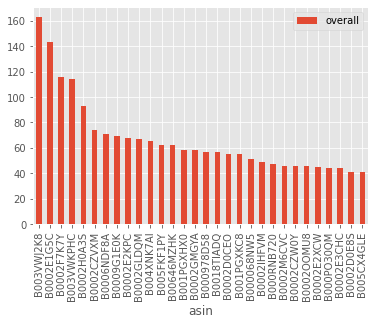

In [ ]:
#Plotting most popular instruments
most_popular.head(30).plot(kind = "bar")

In [ ]:
#Filtering out products and users > 5
min_ratings = 5
filter_instruments = data['asin'].value_counts() > min_ratings
filter_instruments = filter_instruments[filter_instruments].index.tolist()

min_user_ratings = 5
filter_users = data['reviewerID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = data[(data['asin'].isin(filter_instruments)) & (data['reviewerID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(data.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(10227, 11)
The new data frame shape:	(6696, 11)


##*Novelty Implementation*

##**Use ALS to iterate over algorithms**

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633972 sha256=ab4d344834f2971b9671be403c89526dc731bffa8f6f6f9b7aca751d53d8d8b6
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
#Loading packages for machine learning
from surprise import Reader, Dataset, SVD, NMF, accuracy
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import SlopeOne
from surprise import CoClustering
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold, train_test_split, GridSearchCV
from collections import defaultdict

#Reading in data after preprocessing
reader = Reader()
data = Dataset.load_from_df(df_new[['reviewerID','asin', 'overall']], reader)

In [ ]:
def precision_recall_at_k(predictions, k=20, threshold=3):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.859293,0.037145,0.044576
SVDpp,0.866632,1.903375,0.129243
SVD,0.870205,0.651306,0.030547
KNNBaseline,0.957470,0.112597,0.157082
KNNWithMeans,0.975606,0.088614,0.124023
KNNBasic,0.986286,0.094884,0.246806
CoClustering,0.993406,0.301960,0.012414
KNNWithZScore,1.006371,0.170318,0.139895
SlopeOne,1.034328,0.042224,0.037542


##**Training & predicting over BaselineOnly algorithm**

In [ ]:
#BaselineOnly gives us the best rmse so we will train on that
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.87342176, 0.82986237, 0.87984651]),
 'fit_time': (0.0074977874755859375,
  0.008775472640991211,
  0.008335113525390625),
 'test_time': (0.0108795166015625, 0.013184785842895508, 0.009440898895263672)}

In [ ]:
#Splitting into train, test sets and applying the algorithm for predictions
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
a_baseline = accuracy.rmse(predictions)
print(a_baseline)

#Outputting precisions and recalls at k for the given algorithm
precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3)
print("Precision for BaselineOnly: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("Recall for BaselineOnly: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Estimating biases using als...
RMSE: 0.8489
0.848925793468697
Precision for BaselineOnly: 
0.9540035987404409
Recall for BaselineOnly: 
0.9770580296896086


##**Inspect predictions in detail**

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
# Best predictions
best_predictions.head(10)

,uid,iid,rui,est,details,Iu,Ui,err
1536,A31B0LYT2C92SN,B0015RIN6U,5.0,5.000000,{'was_impossible': False},11,13,0.000000
438,A205483DF7XVDE,B00063678K,5.0,5.000000,{'was_impossible': False},8,13,0.000000
767,AOZBVGFIUY44X,B00063678K,5.0,5.000000,{'was_impossible': False},4,13,0.000000
1154,A3SU1JZBMQ5ABZ,B0007L8BQW,4.0,3.999864,{'was_impossible': False},4,4,0.000136
534,A29PEU8AQGFQ9X,B0009EQMZE,4.0,3.999722,{'was_impossible': False},2,3,0.000278
1204,A165EMA3YTIM6A,B000AAGM0M,4.0,4.007279,{'was_impossible': False},7,4,0.007279
621,A12SSZIN555FTL,B0037M62AK,4.0,4.011669,{'was_impossible': False},5,7,0.011669
1504,A2VH0UT5EQFB6P,B0002F75K6,4.0,4.013862,{'was_impossible': False},6,2,0.013862
584,ACWJDL1ZYX8RE,B0002D0JZ6,5.0,4.980783,{'was_impossible': False},4,5,0.019217
597,A1CL807EOUPVP1,B0002E2XCW,5.0,4.975015,{'was_impossible': False},14,25,0.024985


In [ ]:
# Worst predictions
worst_predictions.head(10)

,uid,iid,rui,est,details,Iu,Ui,err
1395,A2RVY2GDMZHH4,B003VWJ2K8,1.0,4.516467,{'was_impossible': False},13,81,3.516467
1659,A14XXL4GMWSI47,B0002II6V0,1.0,4.525563,{'was_impossible': False},4,8,3.525563
1241,A52GGV55KT8AV,B005AGGZ8K,1.0,4.598015,{'was_impossible': False},2,3,3.598015
1246,A3MZWM75KSM1P6,B000XPPURU,1.0,4.603892,{'was_impossible': False},6,10,3.603892
140,A19IFF0DGV0T3E,B000960KNW,1.0,4.604812,{'was_impossible': False},4,9,3.604812
1112,A37WW789WSY81F,B007PKR3SK,1.0,4.633722,{'was_impossible': False},5,7,3.633722
324,A306YUQBEB2R9T,B000EELBQ4,1.0,4.675226,{'was_impossible': False},9,5,3.675226
583,A2YSBRBYSI0524,B005BSOVRY,1.0,4.681793,{'was_impossible': False},4,5,3.681793
611,A19AXCVXAM7NM2,B0010CAEFS,1.0,4.692149,{'was_impossible': False},5,8,3.692149
1245,AJBBU53A0X84I,B0002D01PY,1.0,4.751746,{'was_impossible': False},6,4,3.751746
